In [1]:
%%capture
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
import xarray as xr
import os
import gsw
import time
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d, PchipInterpolator

In [2]:
cluster = SLURMCluster(queue='any2', cores=24, memory='48GB', processes=2)
cluster

In [3]:
client = Client(cluster)
client

Client Scheduler: tcp://192.168.0.5:43699 Dashboard: http://192.168.0.5:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [4]:
from dask import delayed, compute
from dask.diagnostics import ProgressBar
import dask.dataframe as dd
import dask.array as da

In [5]:
@delayed
def get_data(argo_file):
    argo_file = xr.open_dataset(argo_file)
    lats = argo_file.LATITUDE.data
    lons = argo_file.LONGITUDE.data
    lons = np.where(lons<0, lons+360,lons)
    date = argo_file.JULD.data[0]
    date = np.repeat(pd.to_datetime(date).date(), len(lons))
    temp = argo_file.TEMP[:,0].data
    nprof = argo_file.N_PROF.data
#     new_temp =[]
#     for row in temp:
#         new_temp.append(row)
    df = {'date':date,'lat':lats,'lon':lons,'nprof':nprof,'temp':temp}
    pairs = pd.DataFrame(df,columns=['date','lat','lon','nprof','temp'])
    return pairs

@delayed
def merge_data(list_df):
    return pd.concat(list_df)

Here we list the files to open. The function will find and store any profiler inside the ROI since 1999.

In [6]:
ARGO_DIR = '/data/datos/ARGO/data/'
argo_files = [os.path.join(ARGO_DIR,x) for x in os.listdir(ARGO_DIR) if x.endswith('_prof.nc')]
len(argo_files)

7252

Load data and return a pandas datframe of **'date','lat','lon','nprof','temp'**

## This section only needs to be run once!
---

In [54]:
data = merge_data([get_data(argof) for argof in argo_files])

In [55]:
data.compute().head()

,date,lat,lon,nprof,temp
0,1999-04-11,38.856,145.190,0,12.020
1,1999-04-11,40.624,154.200,1,8.212
0,1999-01-01,42.621,155.969,0,8.692
0,1999-04-10,38.087,149.431,0,12.452
1,1999-04-10,39.776,143.998,1,11.268


In [6]:
data = pd.DataFrame([],columns=['date','lat','lon','nprof','temp'])
for file in argo_files:
    data = data.append(get_data(file))

In [28]:
data.head()

,date,lat,lon,nprof,temp
0,1999-04-11,38.856,145.190,0,12.020
1,1999-04-11,40.624,154.200,1,8.212
2,1999-01-01,42.621,155.969,0,8.692
3,1999-04-10,38.087,149.431,0,12.452
4,1999-04-10,39.776,143.998,1,11.268


In [8]:
data.to_csv('latlontemp.txt', index=False)

---

Load previously computed data

In [2]:
data = pd.read_csv('/home/grivera/GitLab/argo/Profiler_list/Output/latlontemp.txt',parse_dates=[0])
data.head()

,date,lat,lon,nprof,platfn,temp
0,1999-04-11,38.856,145.190,0,29006,12.020
1,1999-04-11,40.624,154.200,1,21852,8.212
2,1999-01-01,42.621,155.969,0,21852,8.692
3,1999-04-10,38.087,149.431,0,29007,12.452
4,1999-04-10,39.776,143.998,1,29005,11.268


Fix time variable to have the right dtype

In [3]:
# data['date'] = pd.to_datetime(data['date'])

Helper function to slice data

In [4]:
def filter_data(data, min_lat, min_lon, max_lat, max_lon,time1, time2):
    max_lat = max_lat
    max_lon = max_lon+1
    filt = data[(data['date']>time1)&(data['date']<time2)]
    filt = filt[(filt['lat']>min_lat)&(filt['lat']<max_lat)]
    filt = filt[(filt['lon']>min_lon)&(filt['lon']<max_lon)]
    x_grid = np.arange(min_lon,max_lon,0.5)
    y_grid = np.arange(min_lat,max_lat,0.5)
    return filt, x_grid, y_grid

---

Here we slice our data to make some computations later

In [6]:
date1 = "1999-01-01"
date2 = '2019-12-31'
filt_data, x_grid, y_grid = filter_data(data,-20,250,10.5,300,np.datetime64(date1),np.datetime64(date2))
filt_data.head()

,date,lat,lon,nprof,platfn,temp
1314,2000-07-13,-13.006,252.005997,1,39030,23.901
1342,2000-07-23,-13.048,251.841003,0,39030,23.711
1380,2000-08-03,-13.387,251.442001,1,39030,23.445
1421,2000-08-13,-13.714,250.760002,0,39030,23.454
1458,2000-08-24,-13.921,250.117996,7,39030,23.634


In [7]:
# x_grid = np.arange(260,280,1)
# y_grid = np.arange(-20,10,1)
H, xedges, yedges =np.histogram2d(filt_data['lon'], filt_data['lat'], bins=(x_grid, y_grid))
H = H.T
H.shape

(60, 101)

In [8]:
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
plt.style.use('seaborn-paper')

proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(subplot_kw=dict(projection=proj),figsize=(24,12))
ax.set_xticks(np.arange(0,360,5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90,90,2.5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
X, Y = np.meshgrid(xedges, yedges)

hq_land = cfeature.NaturalEarthFeature(
                            category='physical',
                            name='land',
                            scale='50m',
                            facecolor=cfeature.COLORS['land'])
hq_border = cfeature.NaturalEarthFeature(
                            category='cultural',
                            name='admin_0_countries',
                            scale='50m',
                            facecolor=cfeature.COLORS['land'],
                            edgecolor='black')
#ax.add_feature(hq_land)
ax.add_feature(hq_border)
ax.set_extent([70, 110, -20, 10], crs=proj)

draw = ax.pcolormesh(X, Y, H,edgecolor='w',lw=0.004,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('GnBu',10))
cbar = plt.colorbar(draw, ticks = np.arange(np.min(H),np.max(H),10))
cbar.ax.tick_params(labelsize=15) 
# for i in range(len(yedges)-1):
#     for j in range(len(xedges)-1):
#         text = ax.text(j, i, H[i, j],
#                        ha="center", va="center", color="w")
# ax.plot(lats[~np.isnan(lats)]-180,lons[~np.isnan(lons)],ls='-',lw=1)
ax.coastlines()
fig.savefig('hist_argo.png', dpi=400)

In [9]:
from scipy.stats import gaussian_kde
x = filt_data['lon'].values
y = filt_data['lat'].values
k = gaussian_kde(np.vstack([x, y]))

In [10]:
xi, yi = np.mgrid[x.min():x.max():H.shape[1]*1j,y.min():y.max():H.shape[0]*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

In [11]:
from scipy.integrate import simps
simps(simps(zi.reshape(xi.shape),yi[0]),xi[:,0])

0.9411947494020747

In [12]:
yi.flatten()

array([-19.999     , -19.48211864, -18.96523729, ...,   9.46323729,
         9.98011864,  10.497     ])

In [13]:
np.trapz(np.trapz(zi.reshape(xi.shape)))

4.609524981389975

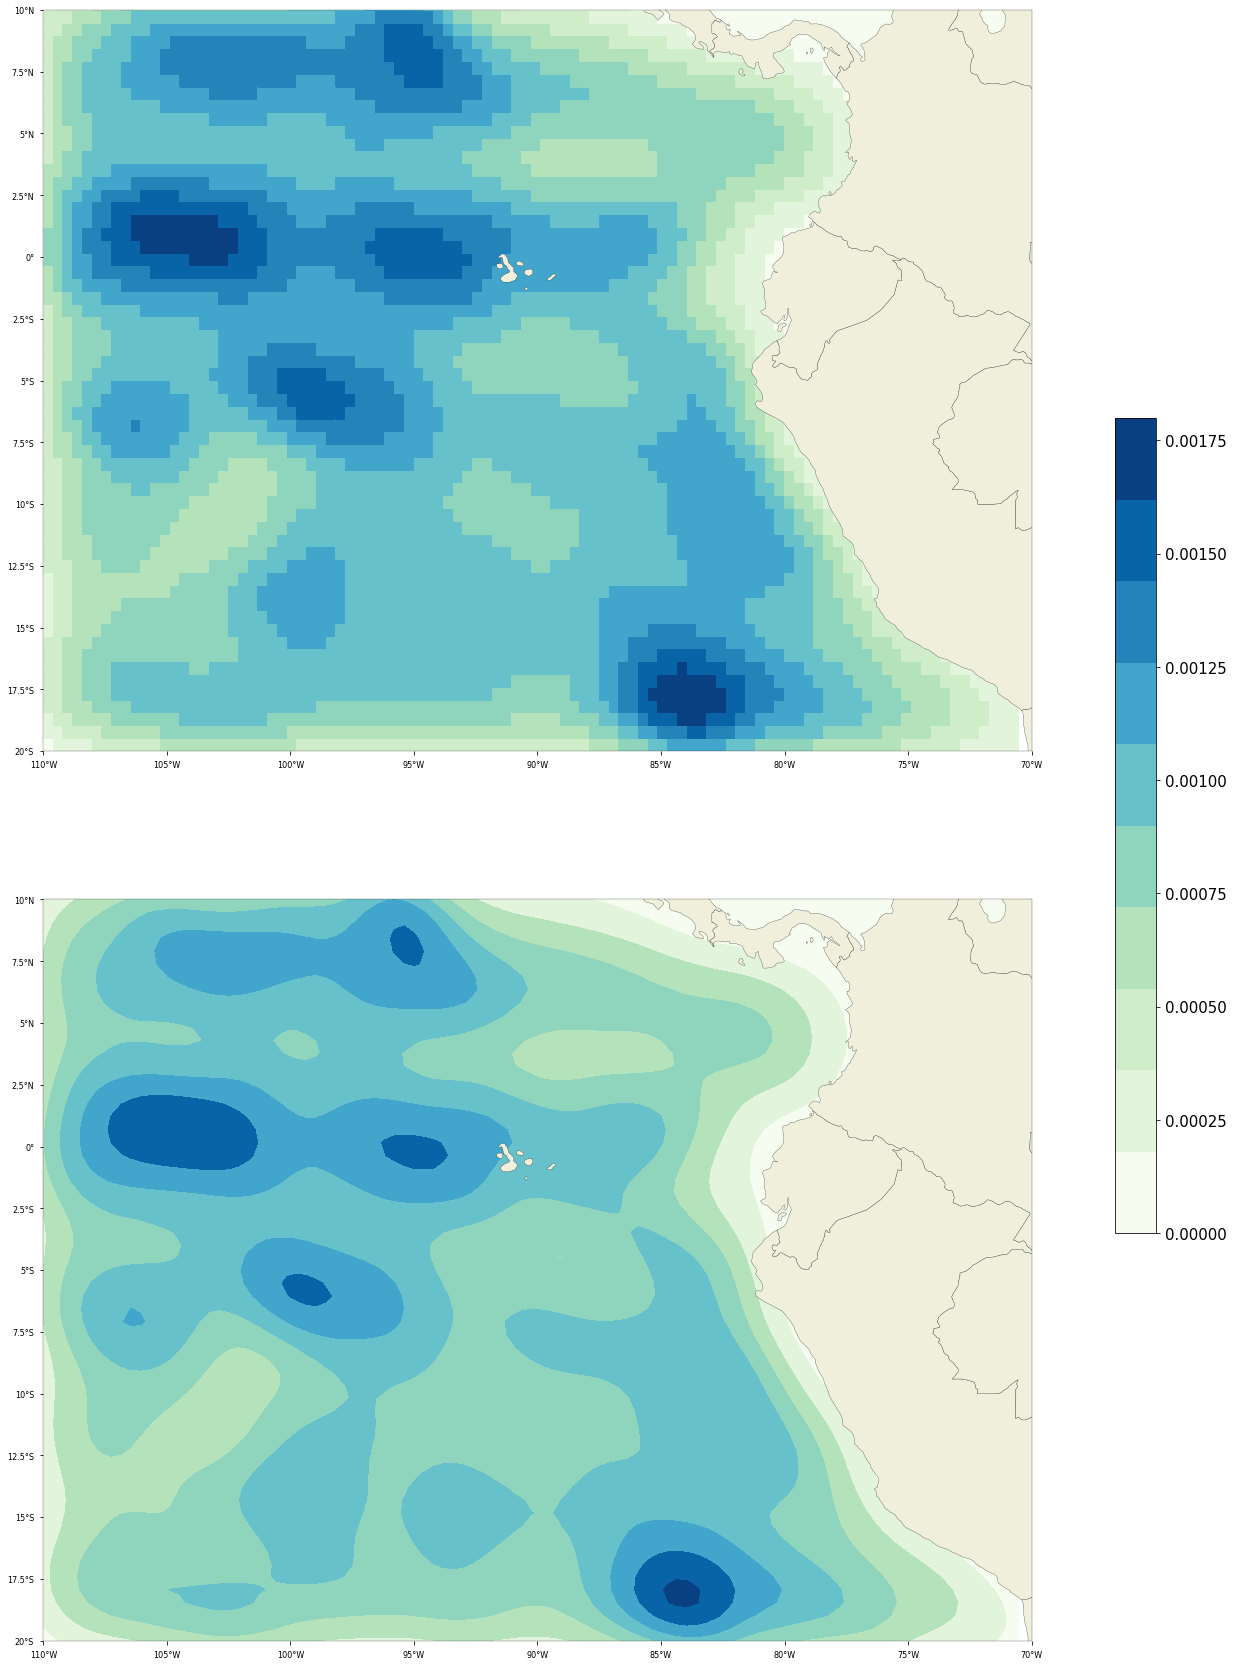

In [14]:
fig ,ax = plt.subplots(2,1,subplot_kw=dict(projection=proj),figsize=(30,30))
ax1 = ax[0] #= fig.add_subplot(211)
ax1.set_xticks(np.arange(0,360,5), crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(-90,90,2.5), crs=ccrs.PlateCarree())
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.add_feature(hq_border)
ax1.set_extent([70, 110, -20, 10], crs=proj)

ax2 = ax[1] #fig.add_subplot(212)
ax2.set_xticks(np.arange(0,360,5), crs=ccrs.PlateCarree())
ax2.set_yticks(np.arange(-90,90,2.5), crs=ccrs.PlateCarree())
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.add_feature(hq_border)
ax2.set_extent([70, 110, -20, 10], crs=proj)

# alpha=0.5 will make the plots semitransparent
a = ax1.pcolormesh(xi, yi, zi.reshape(xi.shape),transform=ccrs.PlateCarree(),cmap=plt.get_cmap('GnBu',10))
ax2.contourf(xi, yi, zi.reshape(xi.shape),transform=ccrs.PlateCarree(),cmap=plt.get_cmap('GnBu',10))
cbar = fig.colorbar(a, orientation='vertical', ax=ax.flat, shrink=0.5)
cbar.ax.tick_params(labelsize=15)

fig.savefig('kde_argo.png', dpi=400)

In [15]:
import math

def roundup(x):
    return int(math.ceil(x / 10.0)) * 10

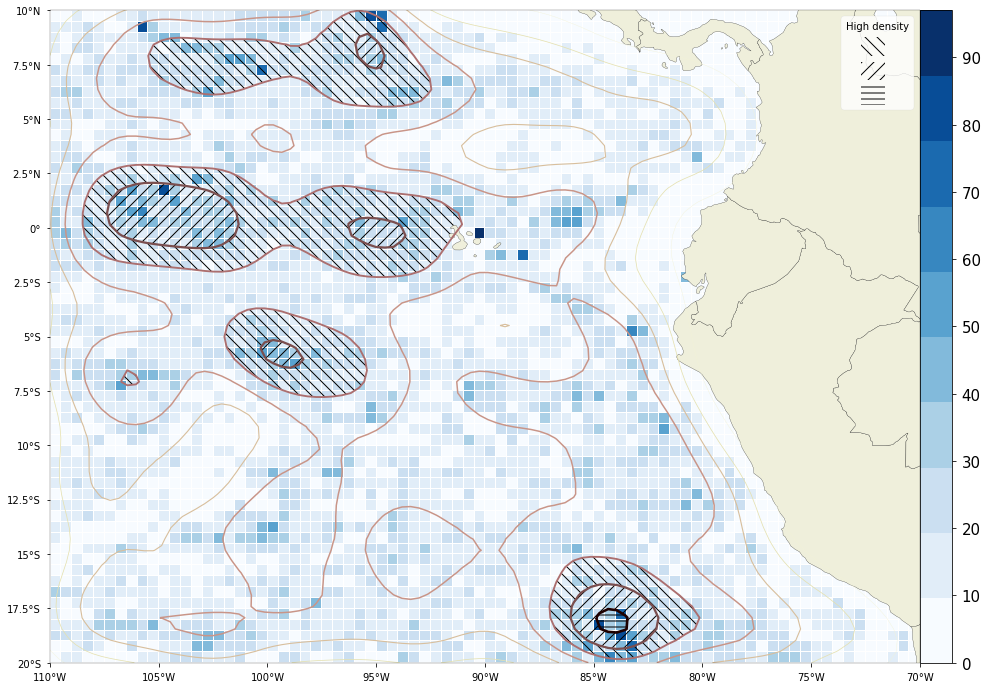

In [19]:
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
plt.style.use('seaborn-paper')

proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(subplot_kw=dict(projection=proj),figsize=(24,12))
ax.set_xticks(np.arange(0,360,5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90,90,2.5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
X, Y = np.meshgrid(xedges, yedges)

hq_land = cfeature.NaturalEarthFeature(
                            category='physical',
                            name='land',
                            scale='50m',
                            facecolor=cfeature.COLORS['land'])
hq_border = cfeature.NaturalEarthFeature(
                            category='cultural',
                            name='admin_0_countries',
                            scale='50m',
                            facecolor=cfeature.COLORS['land'],
                            edgecolor='black')
#ax.add_feature(hq_land)
ax.add_feature(hq_border)
ax.set_extent([70, 110, -20, 10], crs=proj)
draw = ax.pcolormesh(X, Y, H,edgecolor='w',lw=0.004,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('Blues',10))
ax.contour(xi, yi, zi.reshape(xi.shape),levels=8,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('pink_r',8),linewidths=np.linspace(0,3,9))

cmap = plt.get_cmap('pink_r',8)
cmaplist = [cmap(i) for i in range(cmap.N)]
for j in range(len(cmaplist)):
    cmaplist[j] = (1.,1.,1.,0)
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

cs = ax.contourf(xi, yi, zi.reshape(xi.shape),transform=ccrs.PlateCarree(),cmap=cmap,hatches=[None,None,None,None,None,'\\\\', '//','--'],levels=8)
artists, labels = cs.legend_elements()
ax.legend(artists[-3:],['','',''], handleheight=2, title='High density',fancybox=True,fontsize='large')

cbar = plt.colorbar(draw, ticks = np.arange(np.min(H),roundup(np.max(H))+1,10),pad=0)
cbar.ax.tick_params(labelsize=15) 

ax.tick_params(labelsize='medium')
# ax.set_title('2D histogram of ARGO data with density contours computed\n using a gaussian kernel density estimator\n({} - {})'.format(date1,date2),size=20)
fig.savefig('Output/hist+kde_argo.png',dpi=300,bbox_inches='tight')